In [1]:
%pylab inline 
from itertools import product, combinations
from scipy.integrate import odeint

import sys
sys.path.append('/Users/tomshannon/2017Classes/compPhy/TomShannon/utils/animation')
from JSAnimation import IPython_display
from matplotlib import animation

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Solar cells material infromation
solarCell_absorption = 0.92
solarCell_emissivity = 0.88

# PCB material information
pcb_absorption = 0.92
pcb_emissivity = 0.85

# Average absorption and emissivity
absorption = (solarCell_absorption * 0.865) + (pcb_absorption * 0.135)
emissivity = (solarCell_emissivity * 0.865) + (pcb_emissivity * 0.135)

# Total area consisting of six faces (in cm)
area = 0.01

# Specific heat
c = 5.0
c1 = 265.0
c2 = 170.0

# FLux (W/m^2)
solar_flux = 1367
albedo = 406

# Stefan Boltzmann Constant
stefan = 5.67e-8

In [3]:
# Setting up temperature matrix
rows = 30
columns = 30

# Set time scale and initial conditions
t = linspace(0, 100, 1000)
x = linspace(0, 10, rows)
y = linspace(-10, 0, columns)

# Set up differentials 
dx = x[1] - x[0]
dy = y[1] - y[0]

# Make mesh grid

xx, yy = meshgrid(x, y)

In [4]:
def calcLaplacian(state, t, dx, dy):
    
    # Heat capacity = 8.5
    c = 8.5
    
    # Angle normal to sun 
    theta = t % 2*pi
    
    # Unpack state
    state = state.reshape((rows, columns))
    Ta = zeros((rows+2, columns+2))
    Ta[1:-1, 1:-1] = state
    
    # Insulated bouundary conditions 
    Ta[0, :] = Ta[1, :]
    Ta[-1,:] = Ta[-2,:]
    Ta[:,-1] = Ta[:,-2]
    Ta[:, 0] = Ta[:, 1]
    
    # Heat flux in and out
    powerIn1 = c * solar_flux * area * cos(theta - pi/2) * (theta < pi) * absorption
    powerOut1 = stefan * emissivity * state[0, :]**4 * area
    
    powerIn2 = c * solar_flux * area * cos(theta) * (theta < (pi/2) or theta > (3*pi/2)) * absorption
    powerOut2 = stefan * emissivity * state[:, 0]**4 * area
    
    powerIn3 = c * albedo * area * absorption 
    powerOut3 = stefan * emissivity * state[-1, :]**4 * area
    
    powerIn4 = c * solar_flux * area * cos(theta - pi) * (theta > pi/2 and theta < (3*pi/2)) * absorption
    powerOut4 = stefan * emissivity * state[:, -1]**4 * area
    
    # Apply fluxes to boundary conditions
    Ta[0, 1:-1] = powerIn1 + c1 - powerOut1
    Ta[1:-1, 0] = powerIn2 + c1 - powerOut2
    Ta[-1, 1:-1] = powerIn3 + c2 - powerOut3
    Ta[1:-1, -1] = powerIn4 + c1  - powerOut4
    
    # Seperated partial derivative for laplacian of temperature
    partialXX = ((Ta[:, :-2] - 2*Ta[:,1:-1] + Ta[:, 2:])) / dx**2
    partialYY = ((Ta[:-2,:] - 2*Ta[1:-1, :] + Ta[2:, :])) / dy**2
    
    laplacian = partialXX[1:-1,  :] + partialYY[:, 1:-1]
    laplacian.reshape((-1,))
    
    dcdt = laplacian
    
    return dcdt.reshape(-1)

In [5]:
# Use odeint to solve system 
T0 = xx
ans2 = odeint(calcLaplacian, T0.reshape((-1,)), t, (dx, dy))


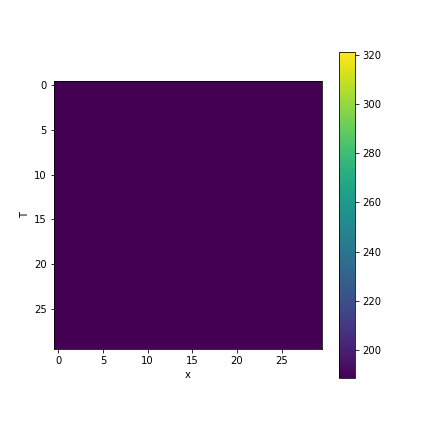
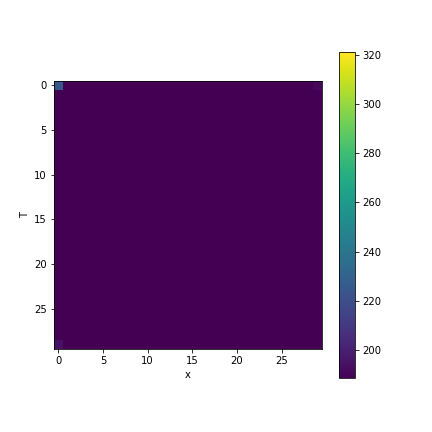
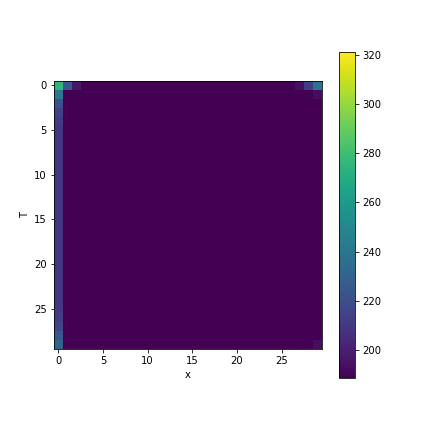
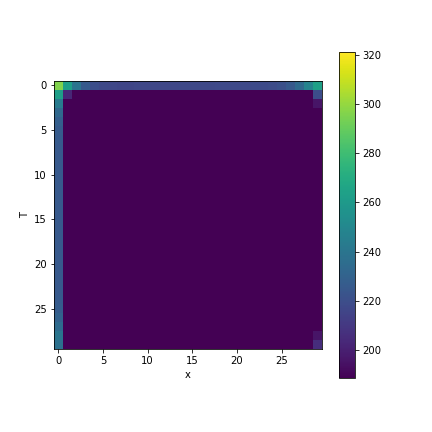
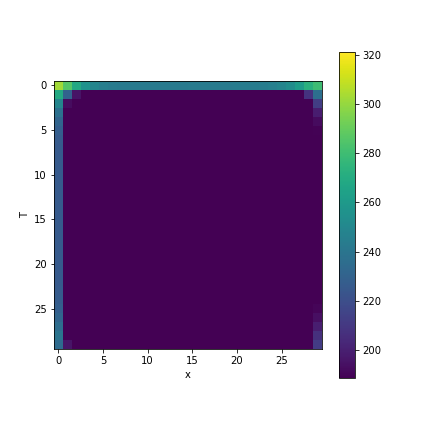
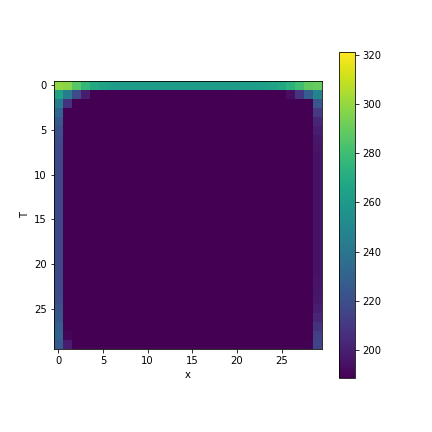
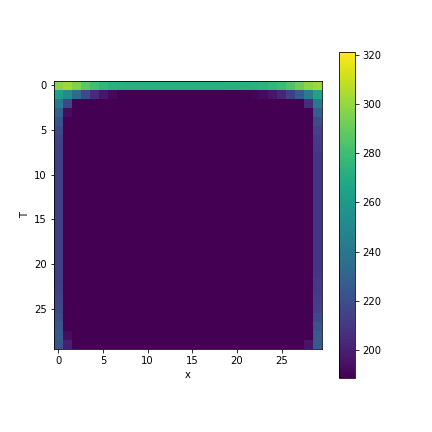
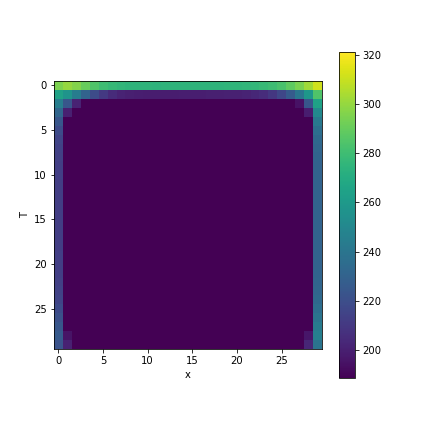
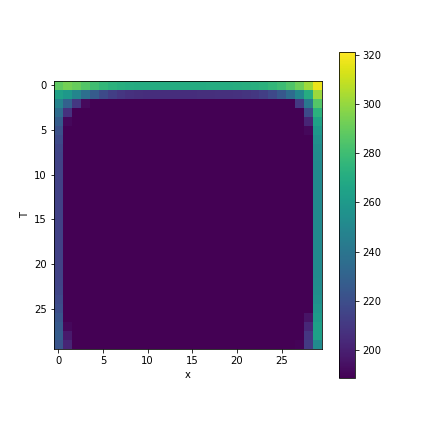
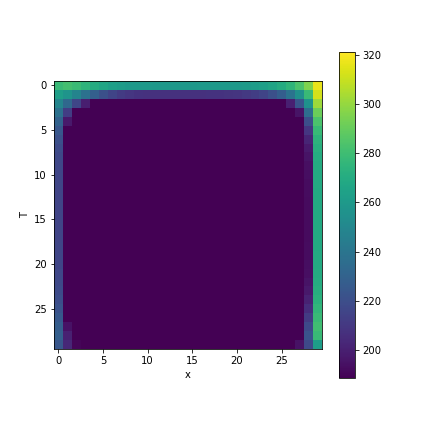
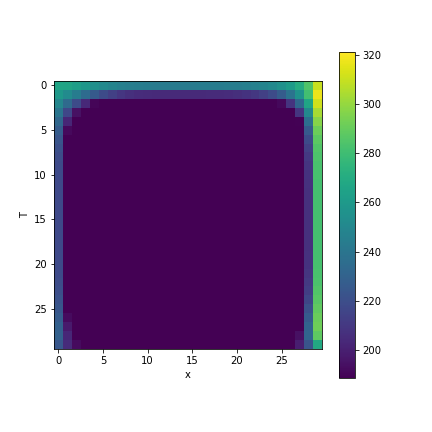
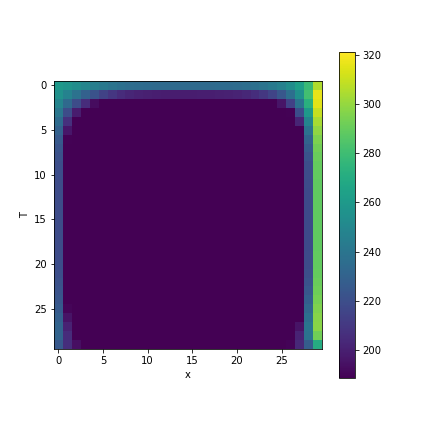
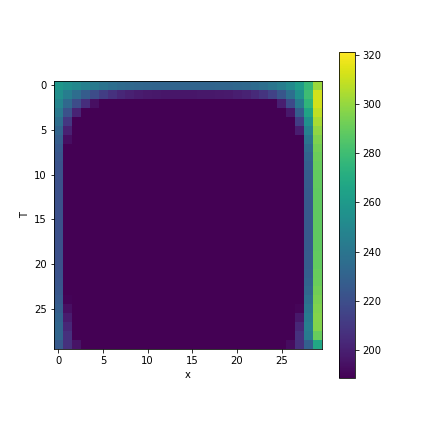
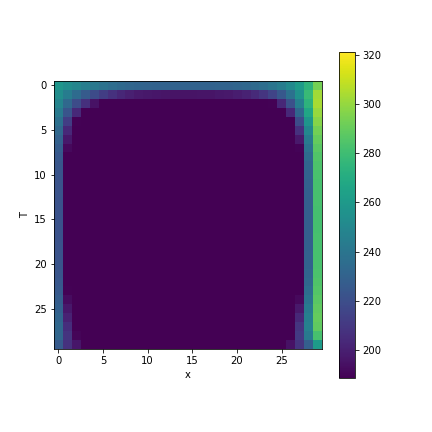
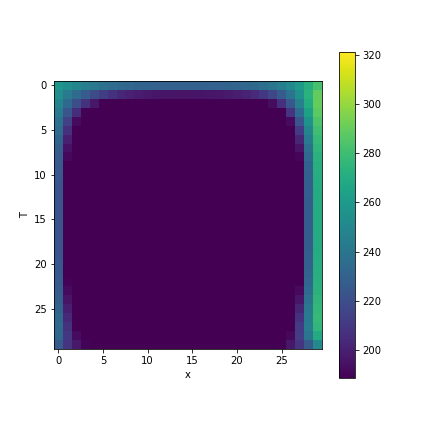
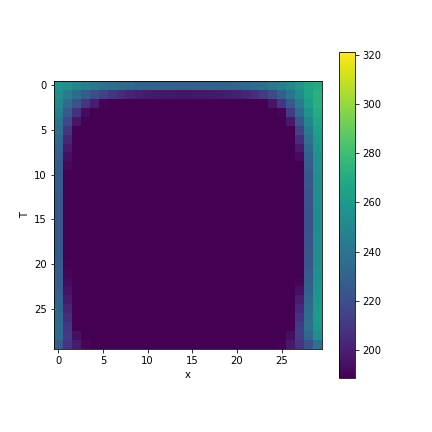
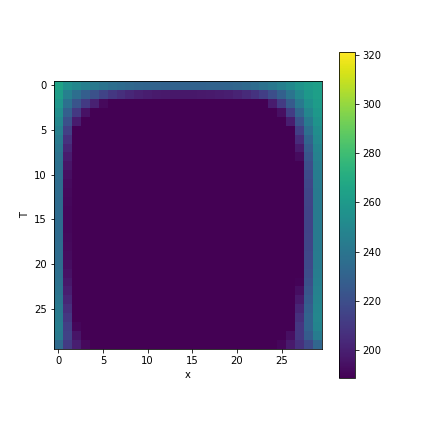
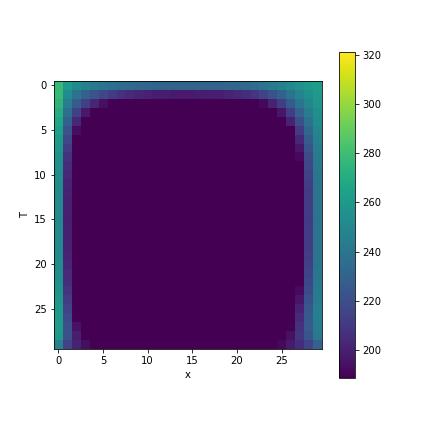
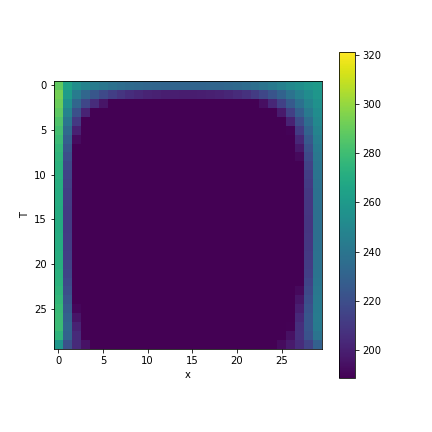
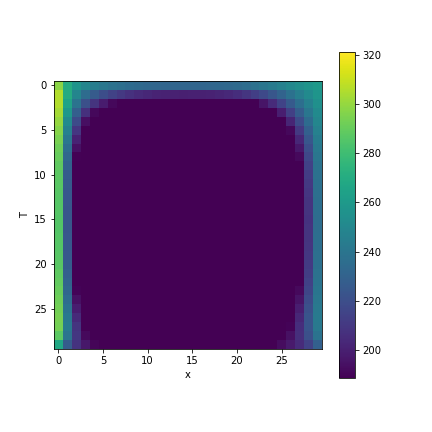
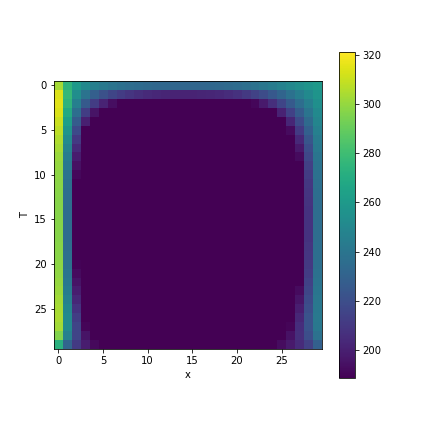
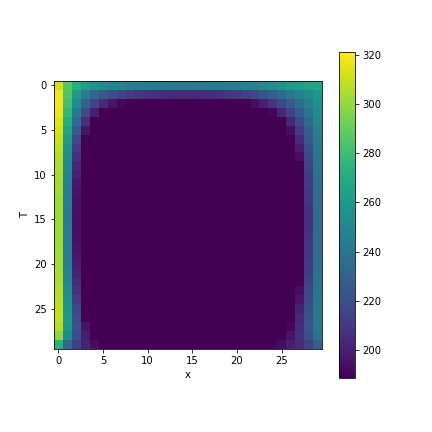
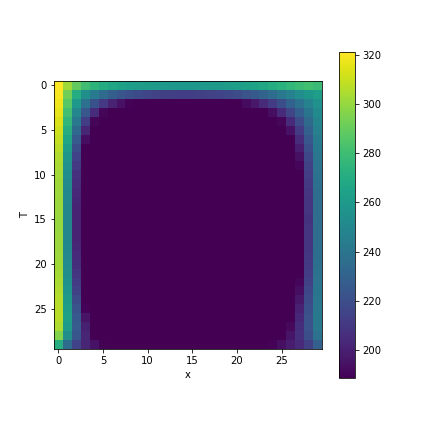
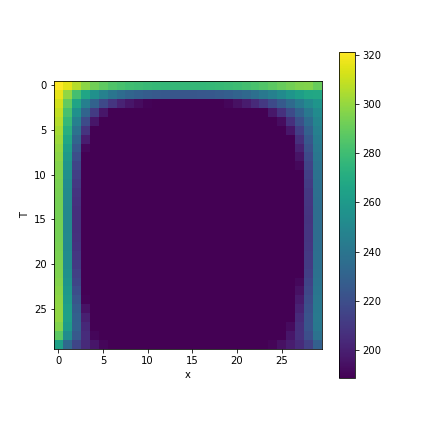
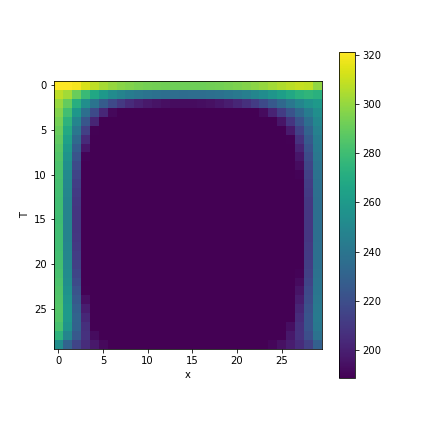
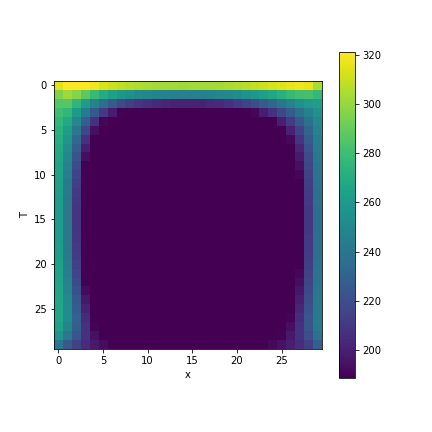
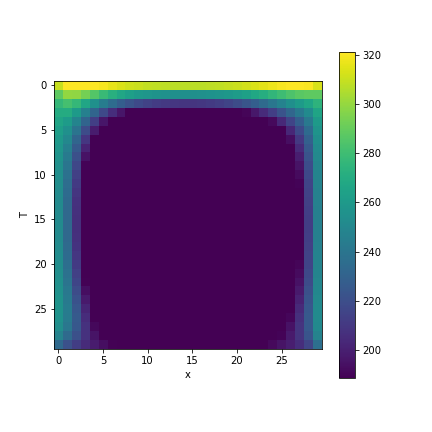
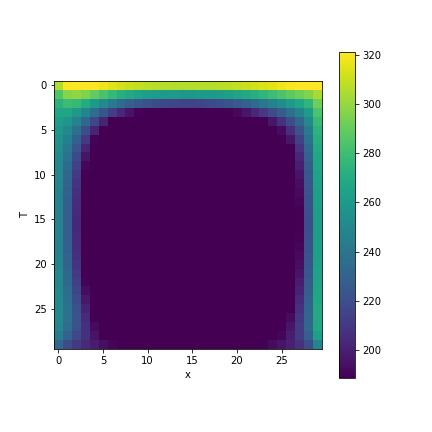
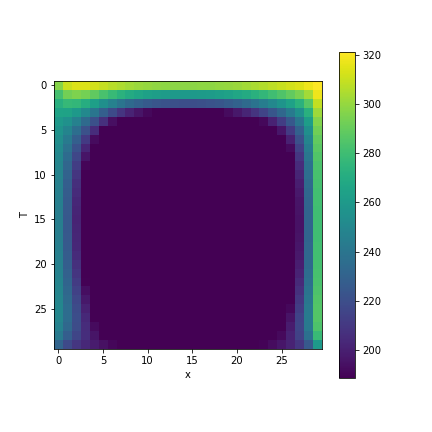
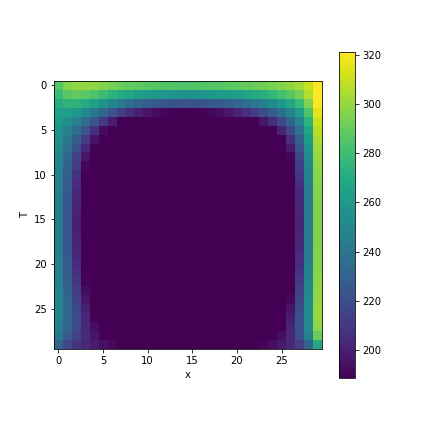
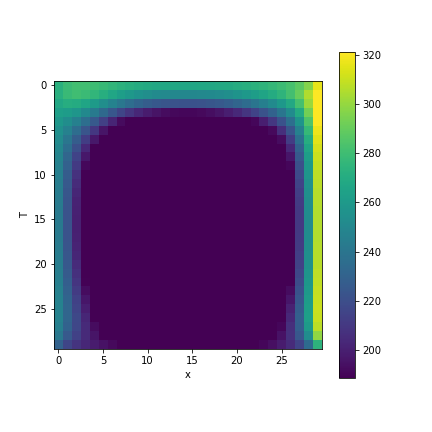
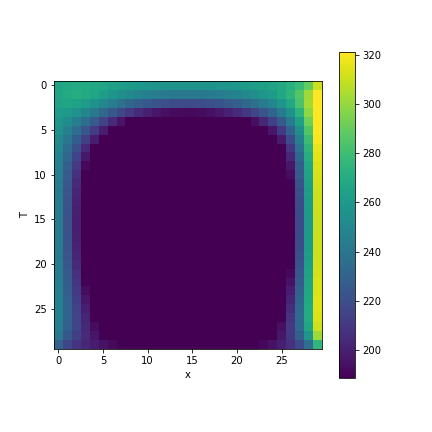
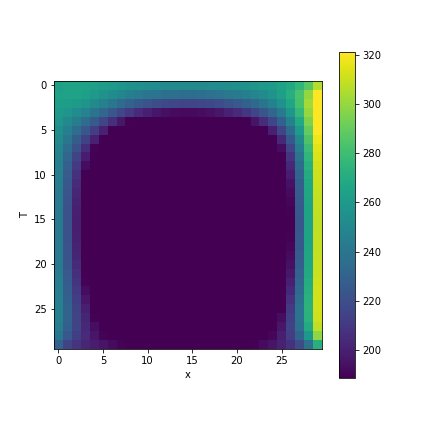
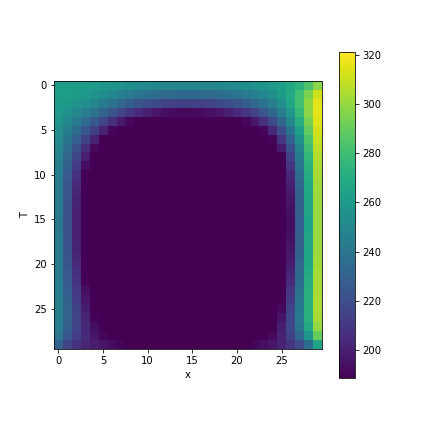
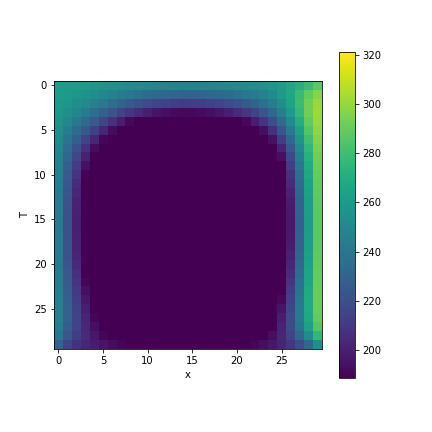
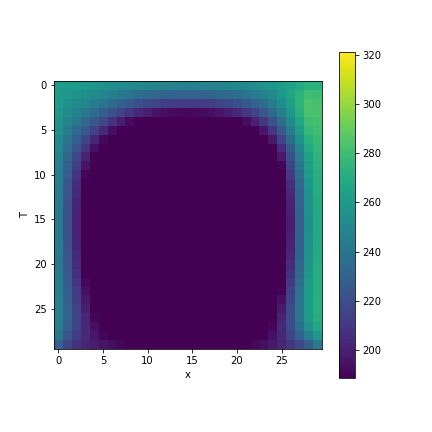
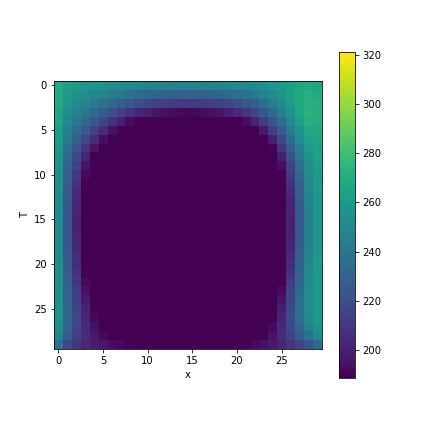
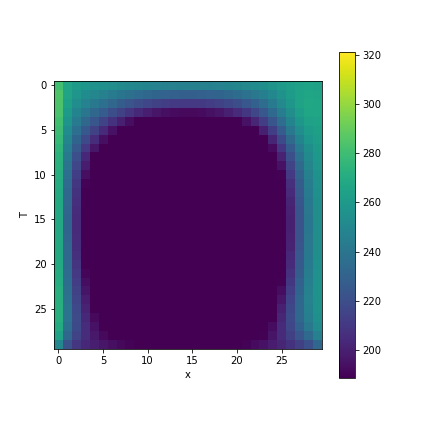
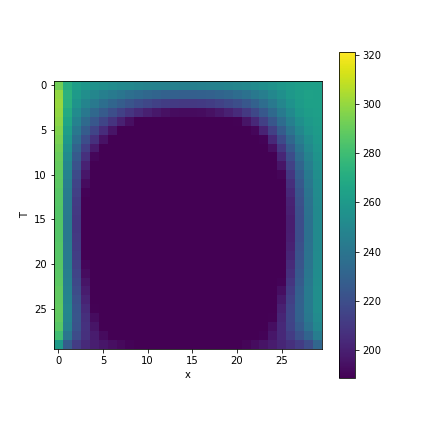
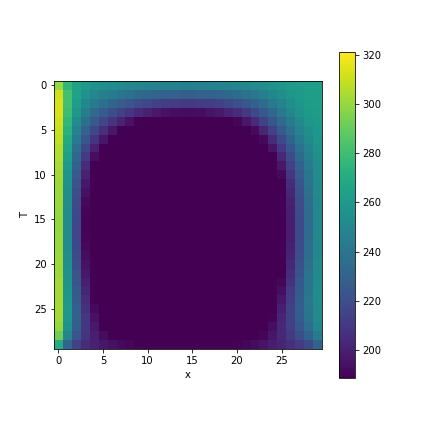
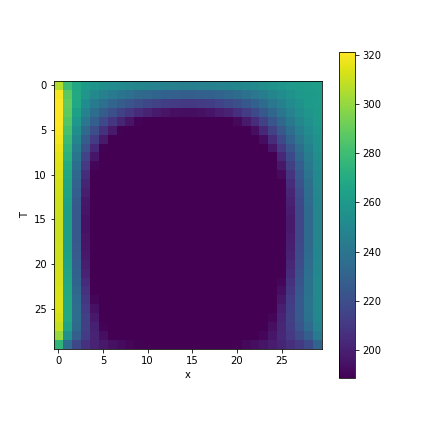
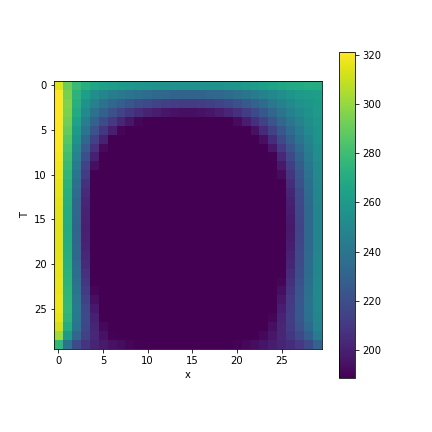
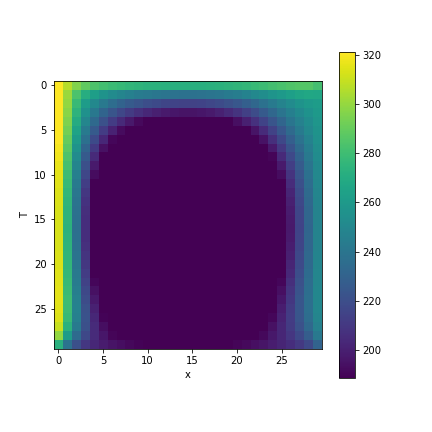
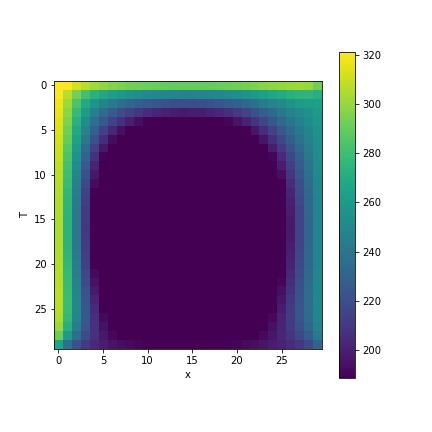
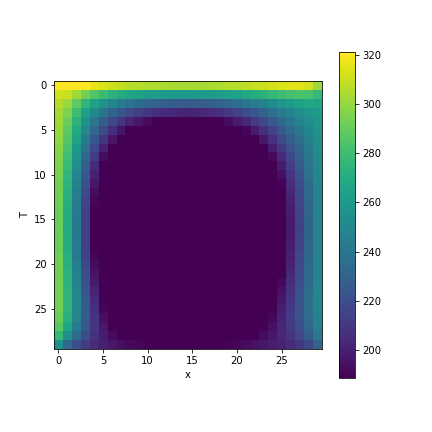
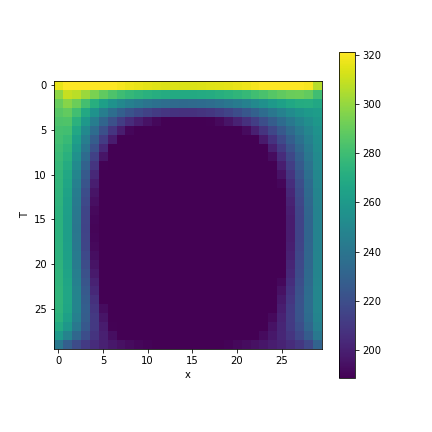
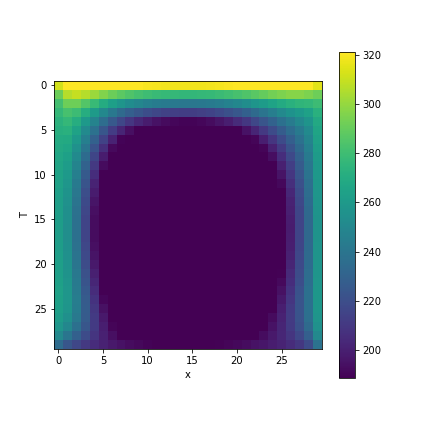
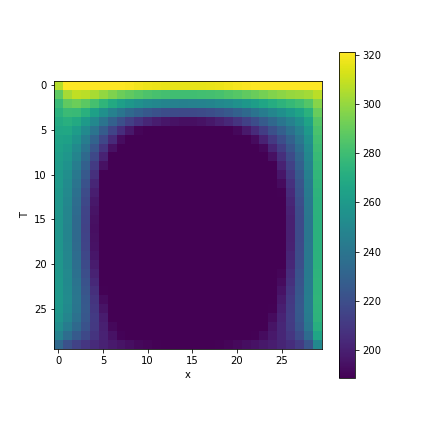
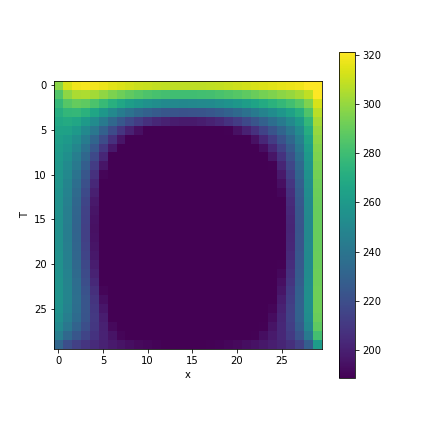
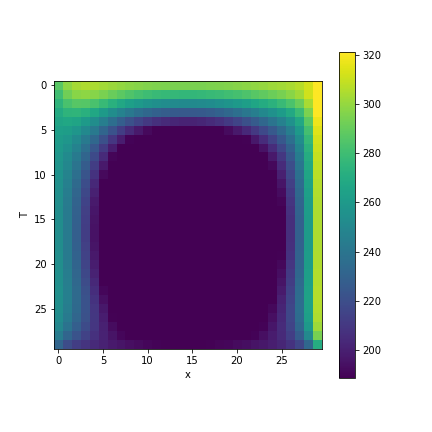
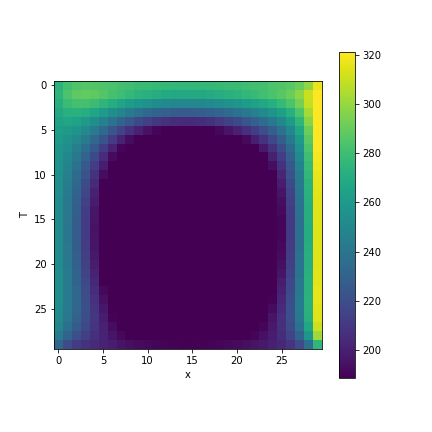
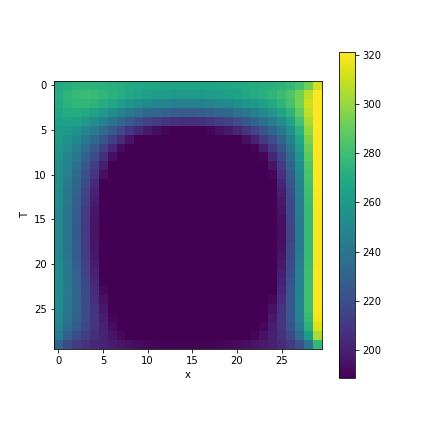
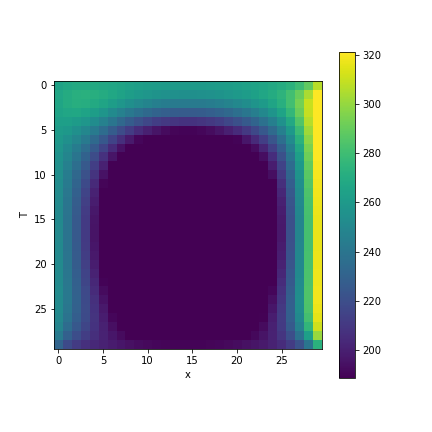
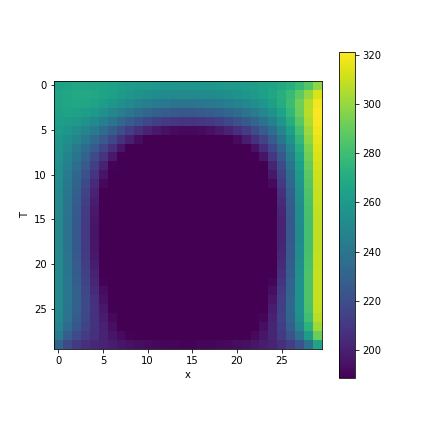
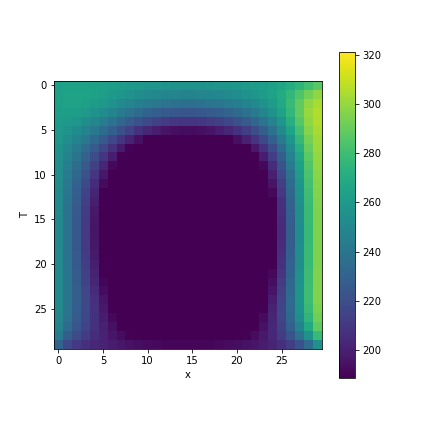
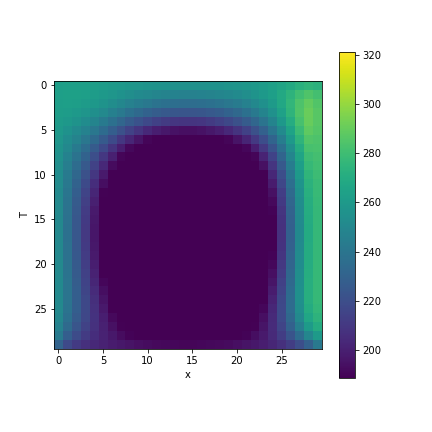
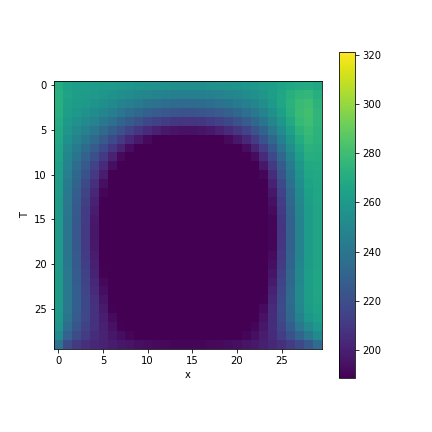
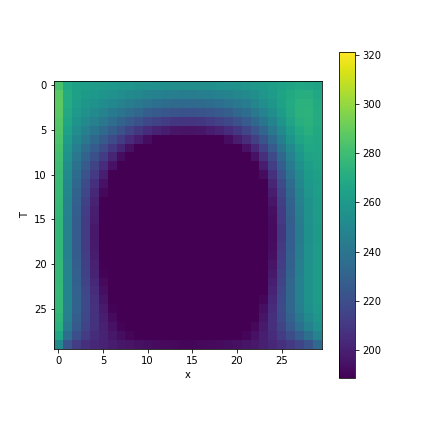
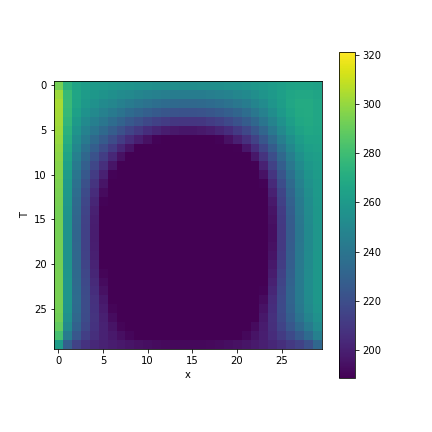
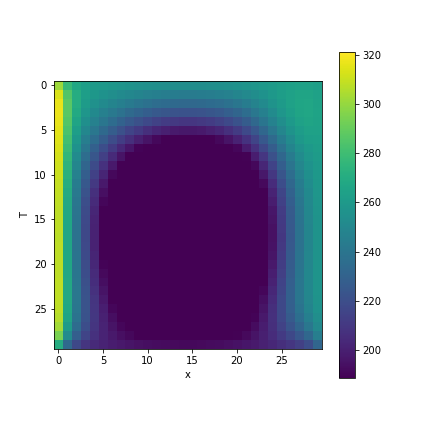
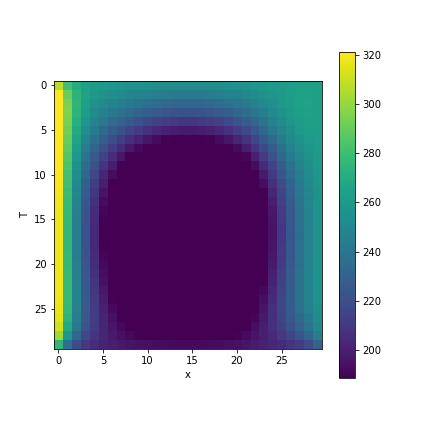
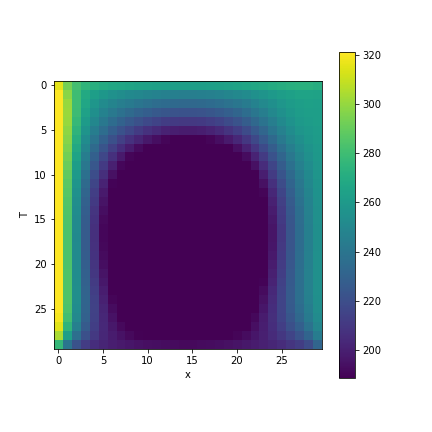
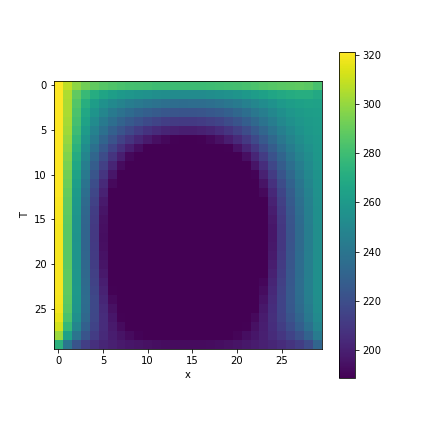
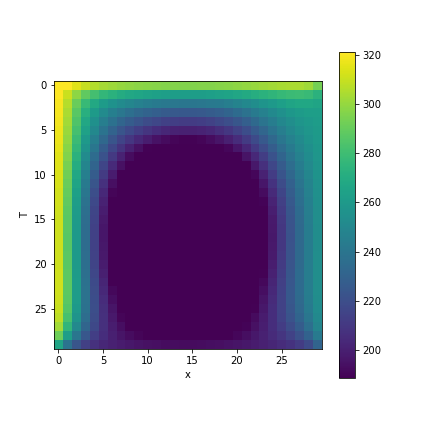
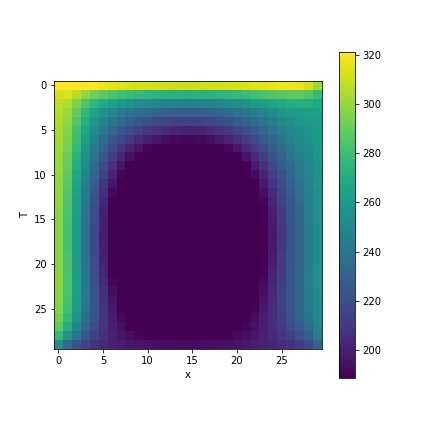
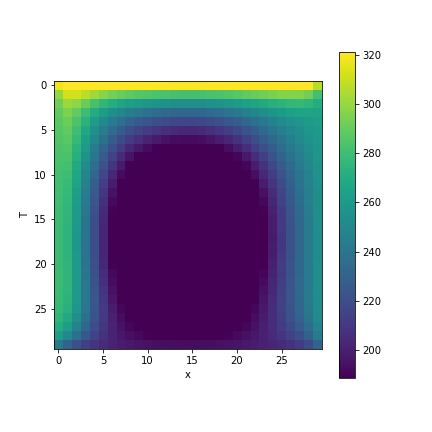
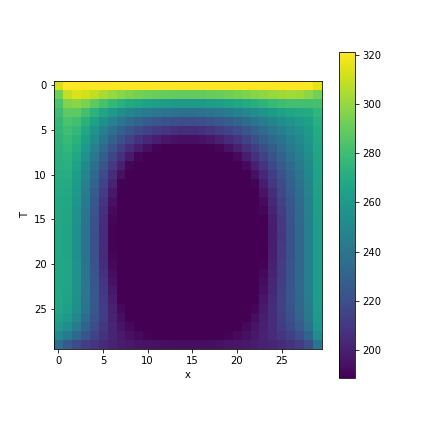
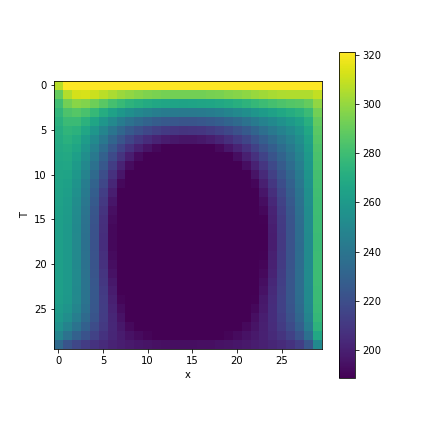
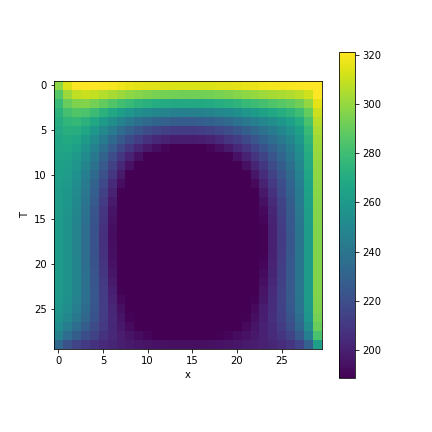
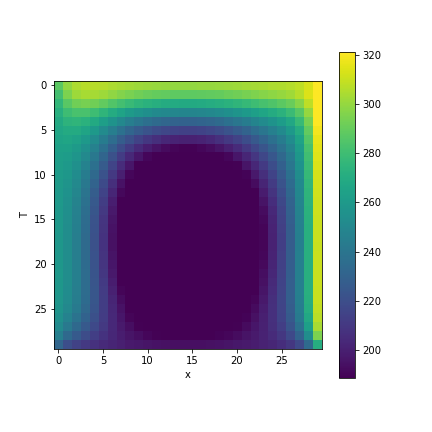
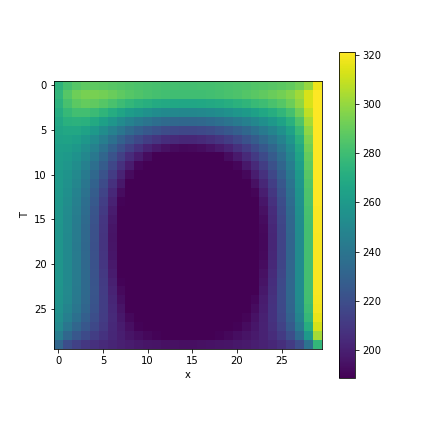
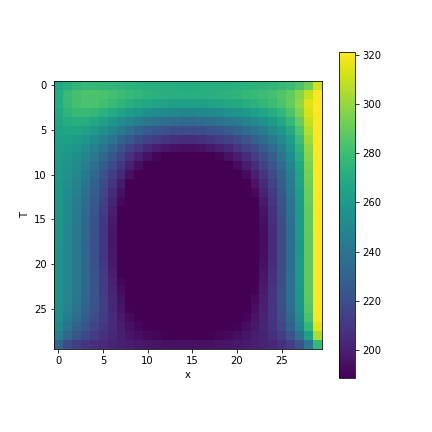
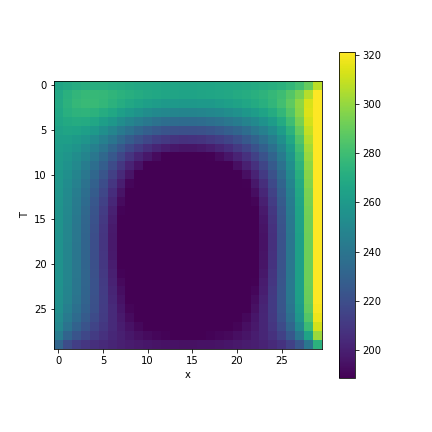
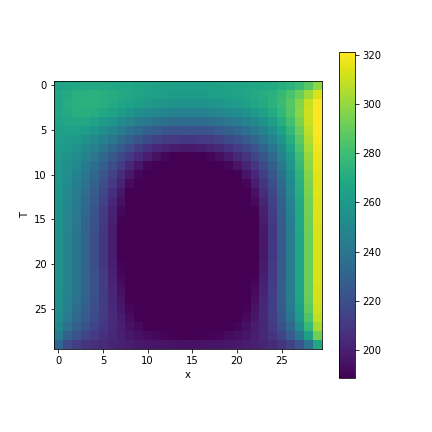
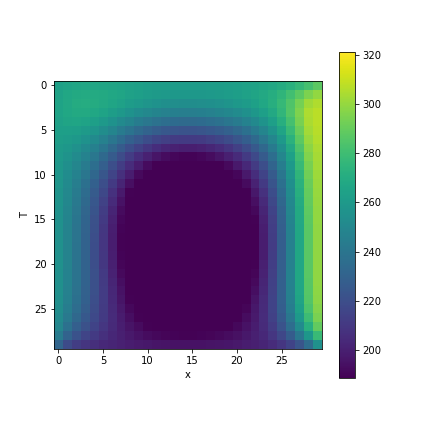
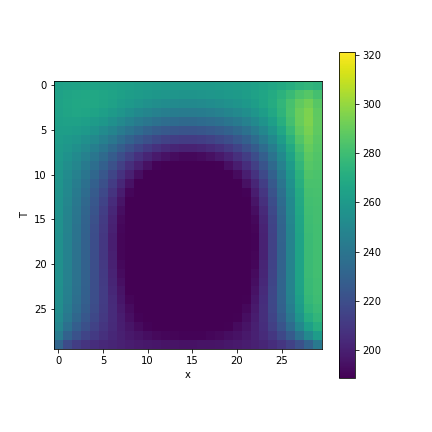
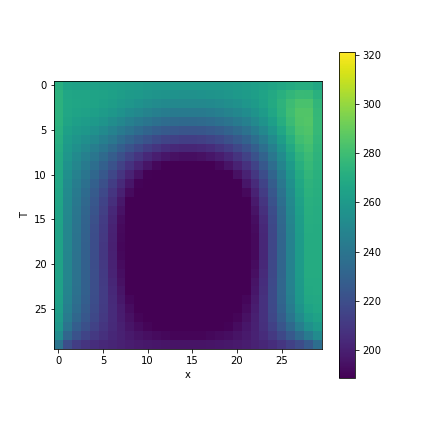
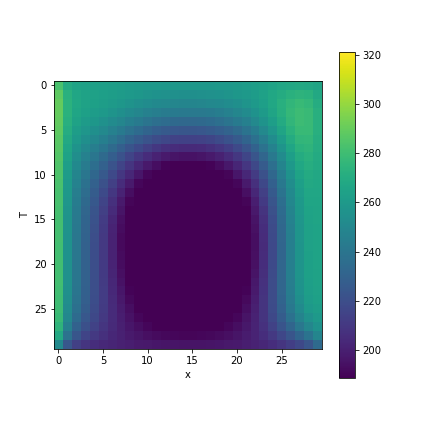
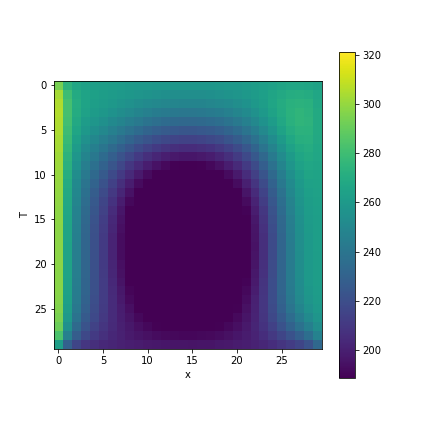
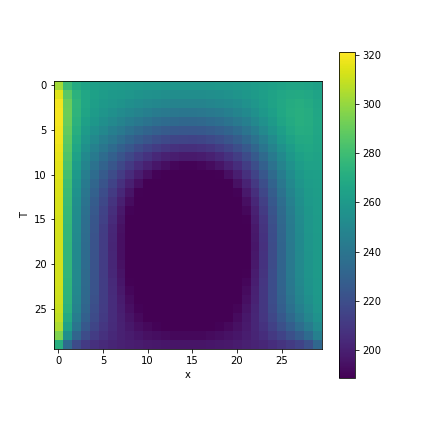
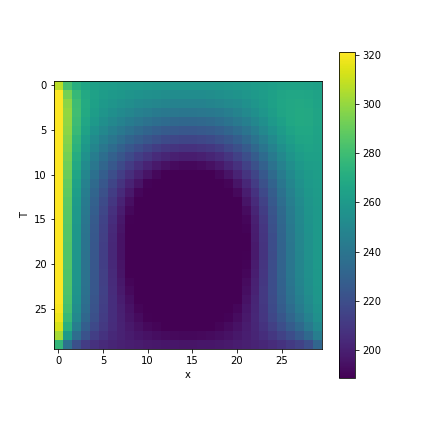
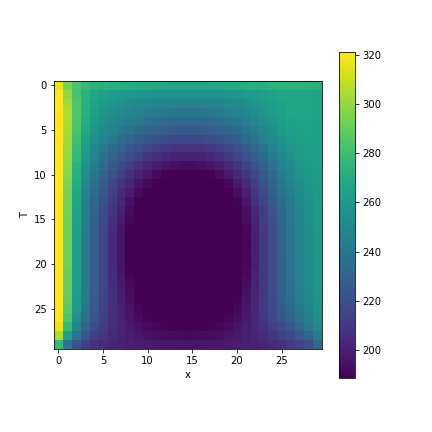
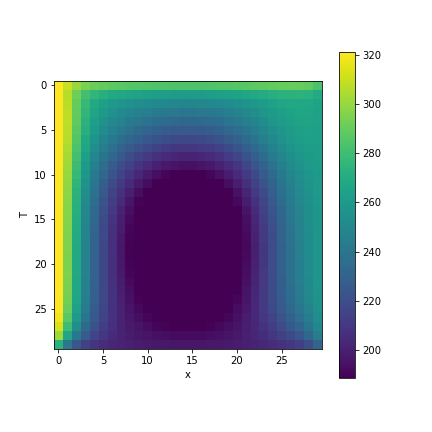
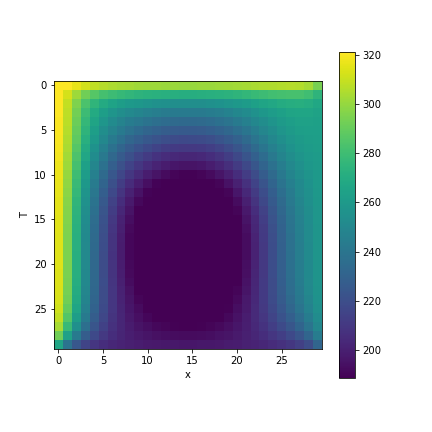
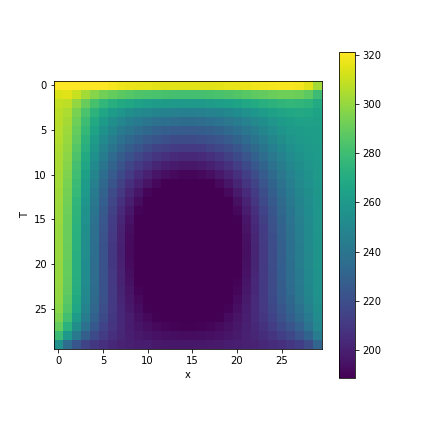
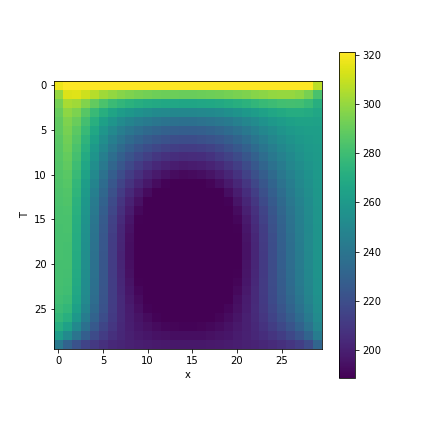
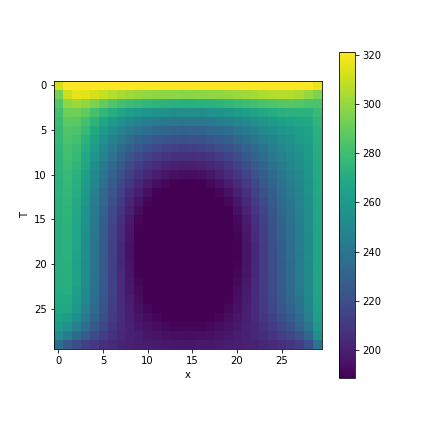
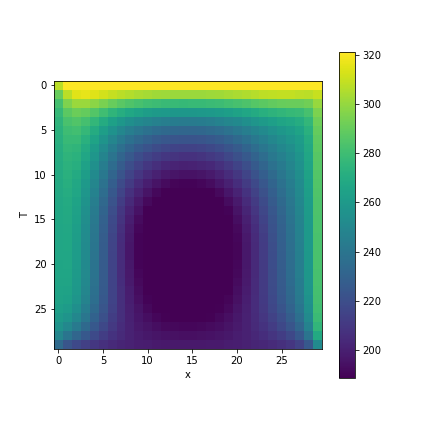
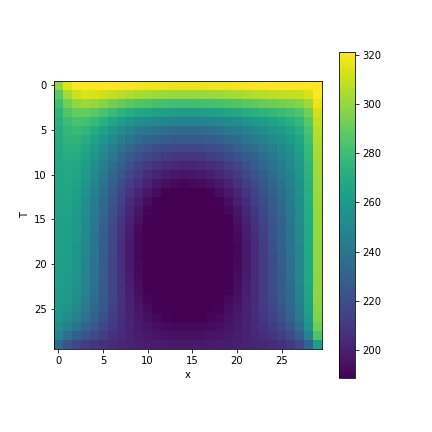
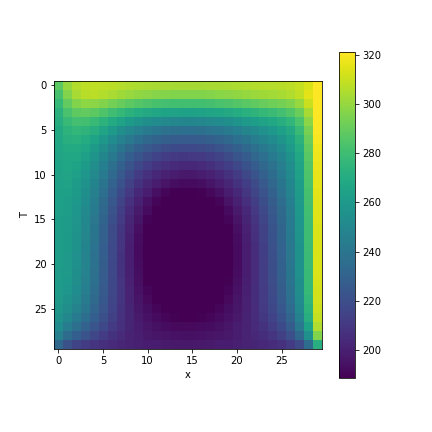
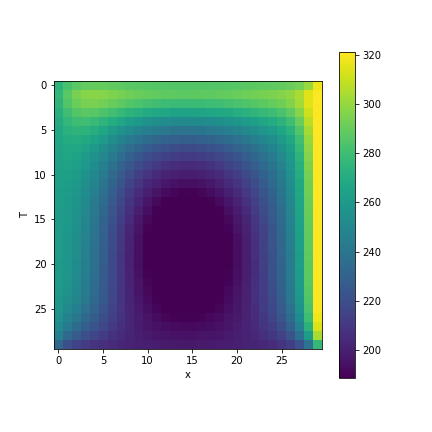
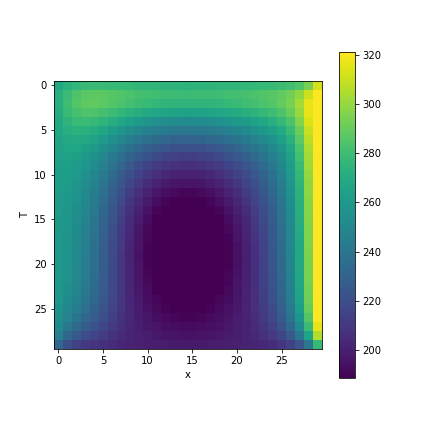
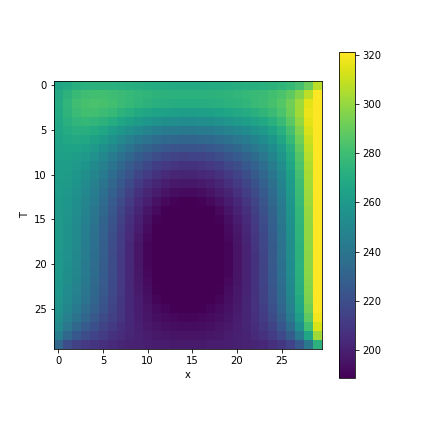
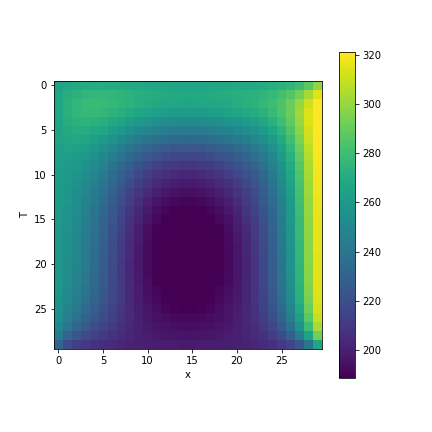
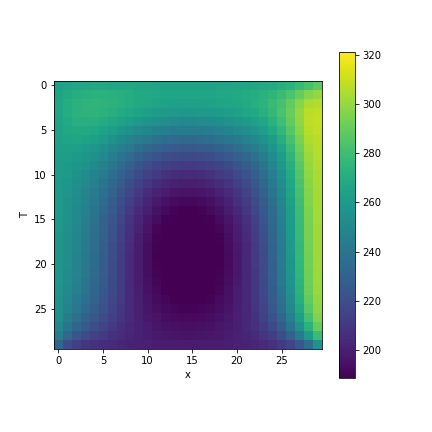
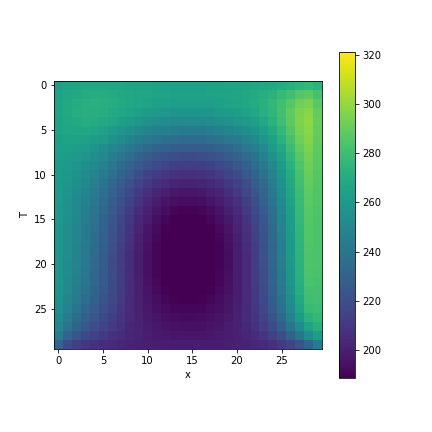
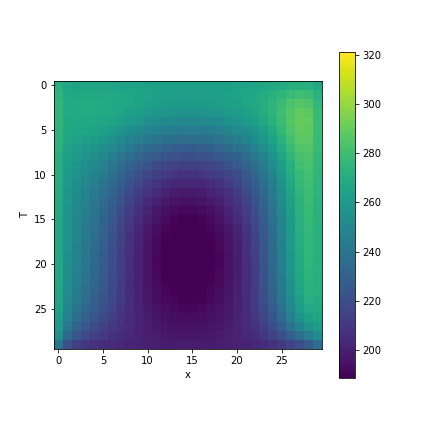
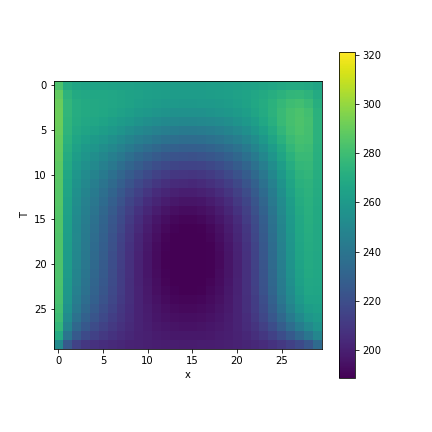
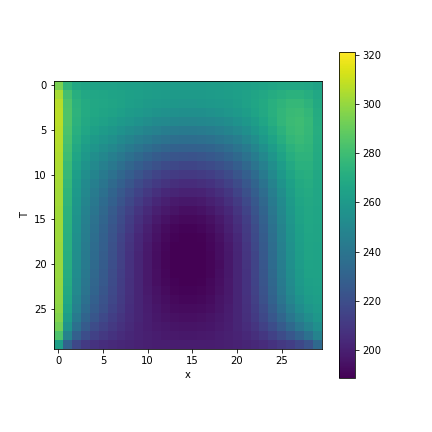
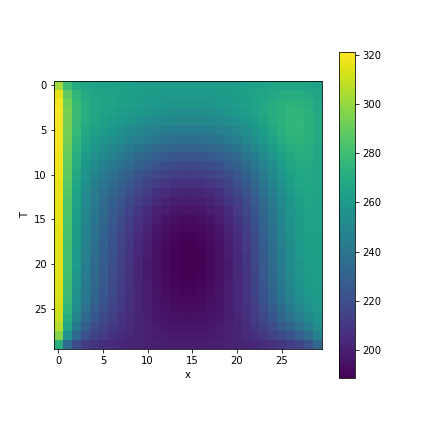
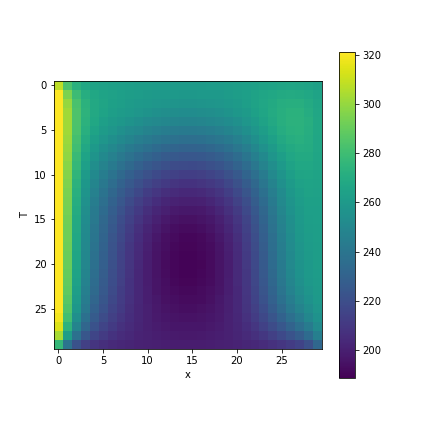
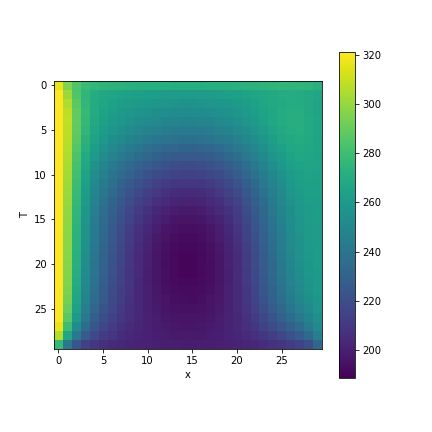
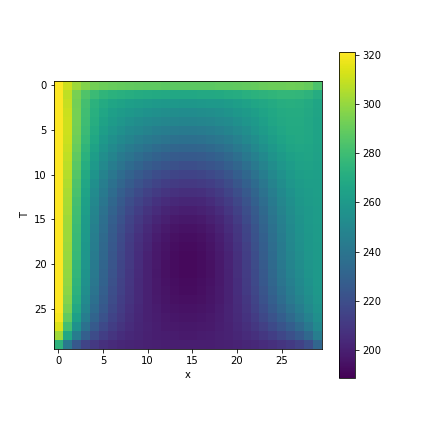
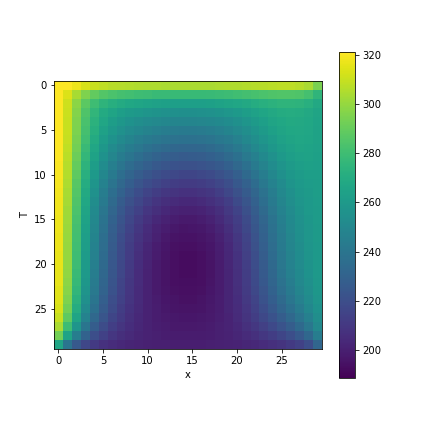
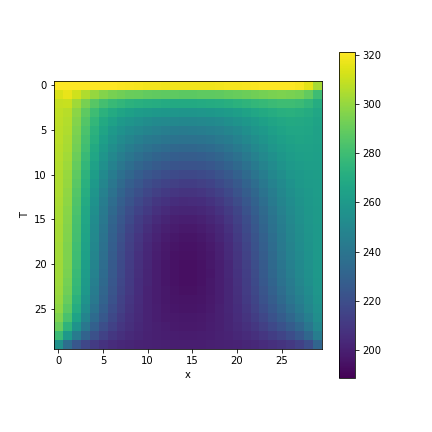
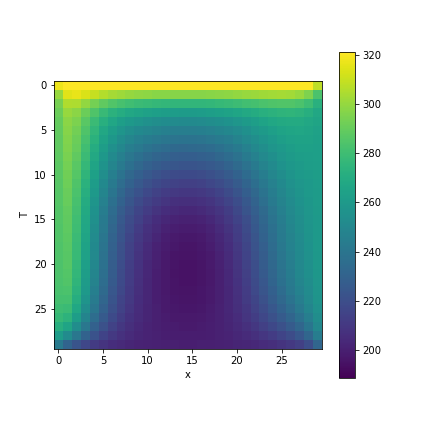
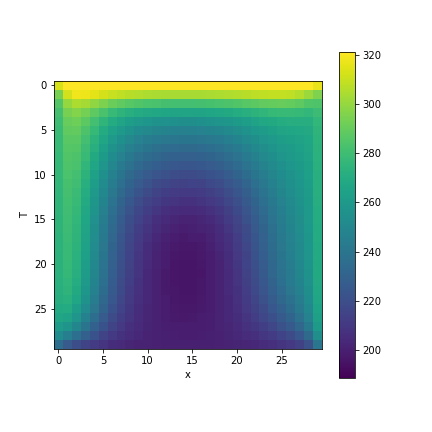
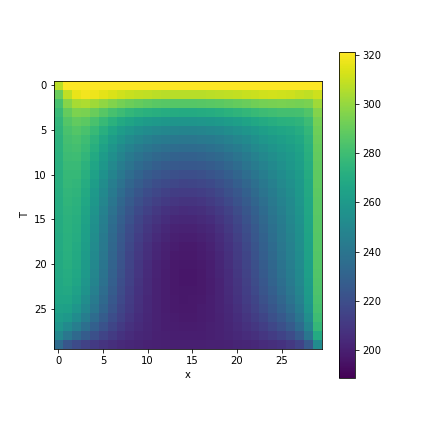
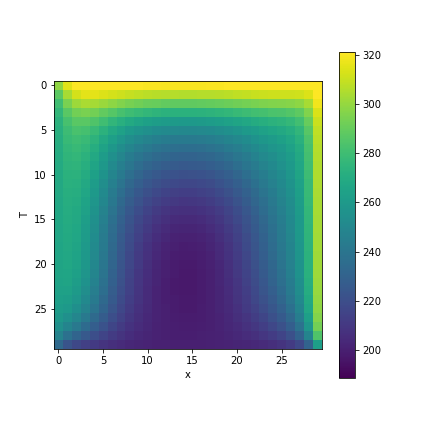
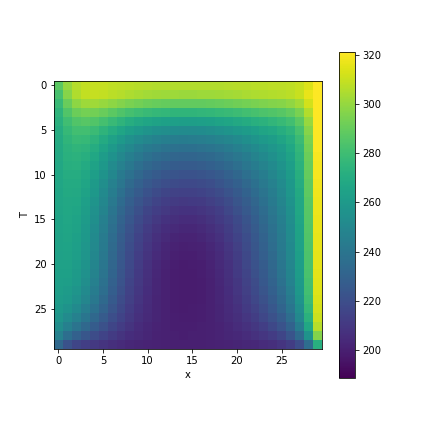
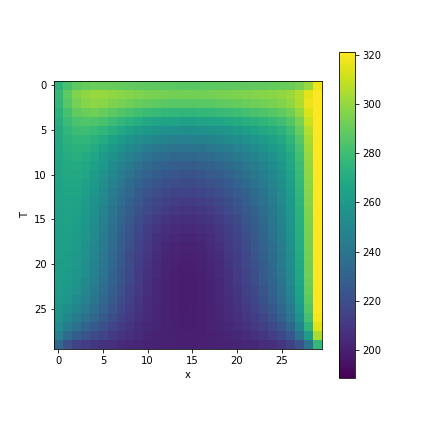
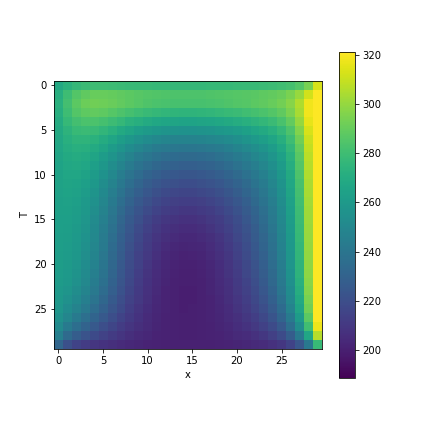
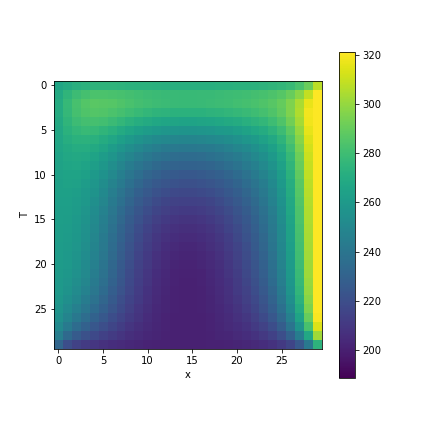
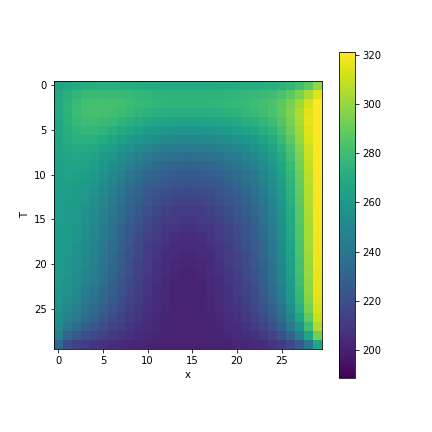
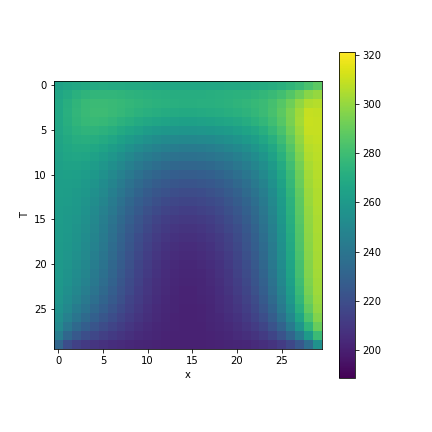
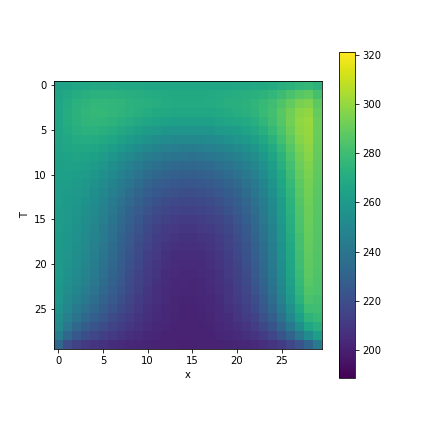
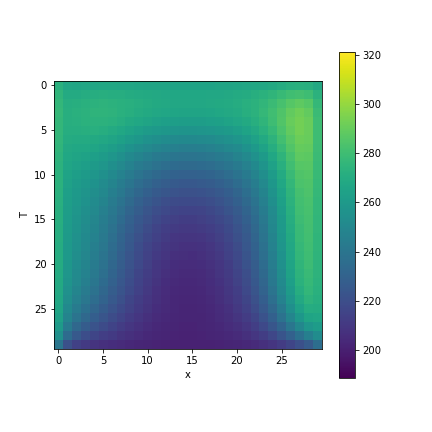
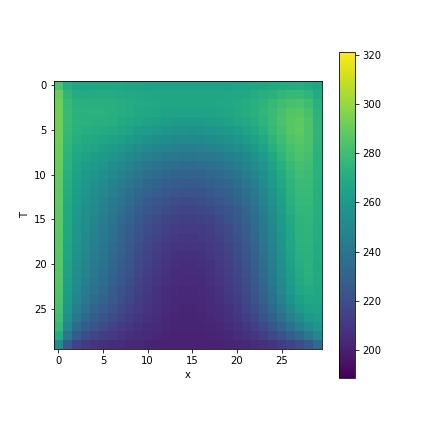
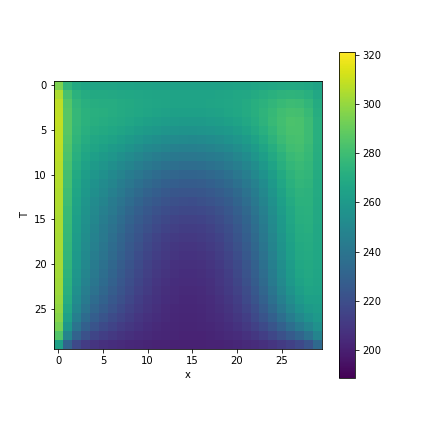
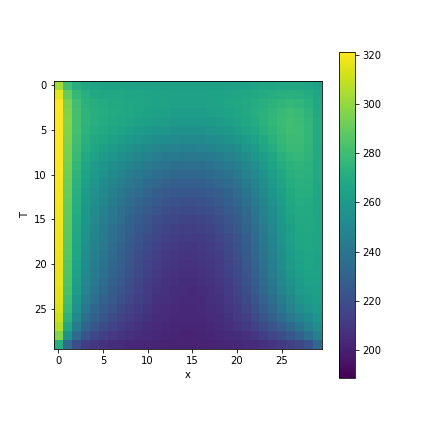
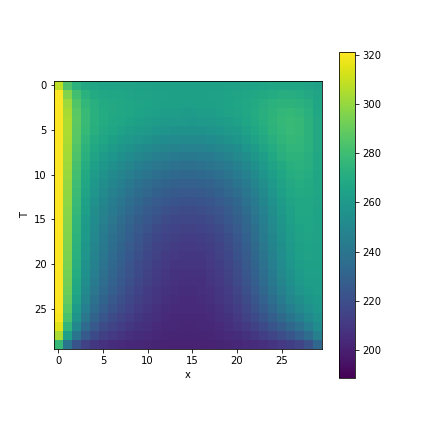
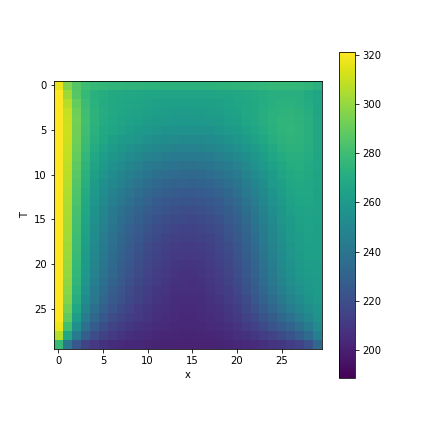
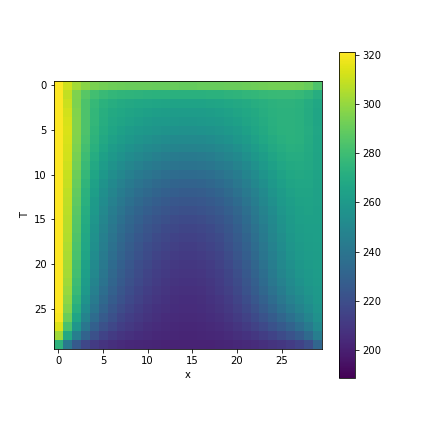
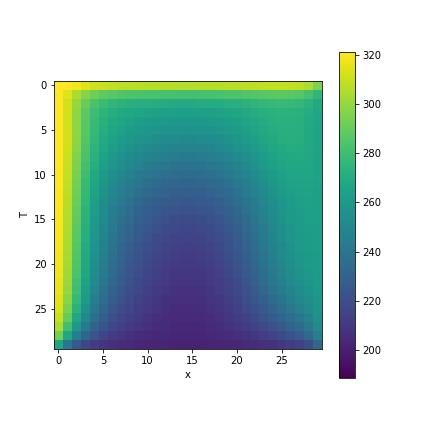
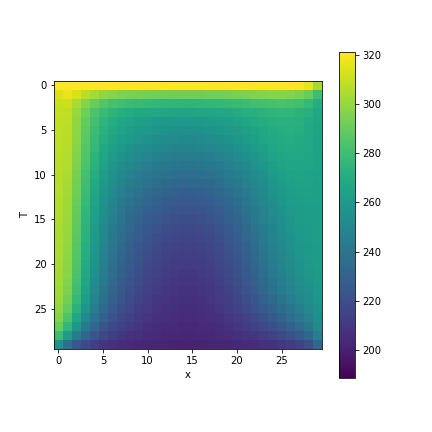
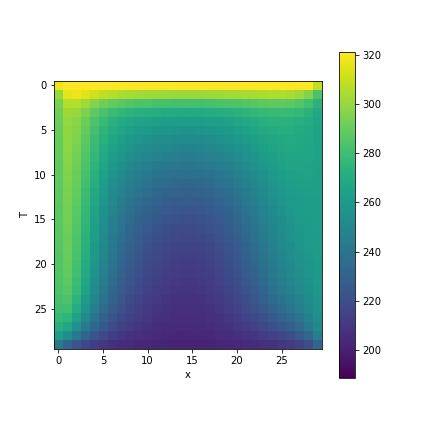
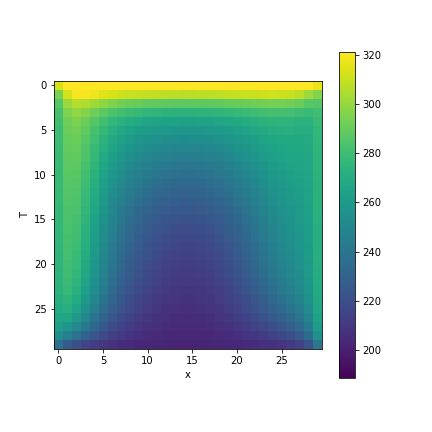
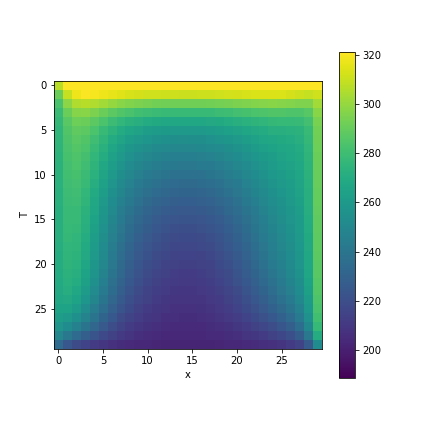
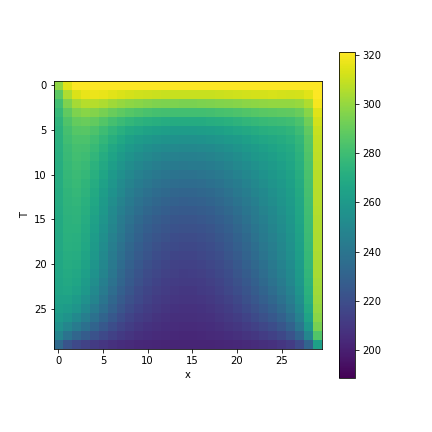
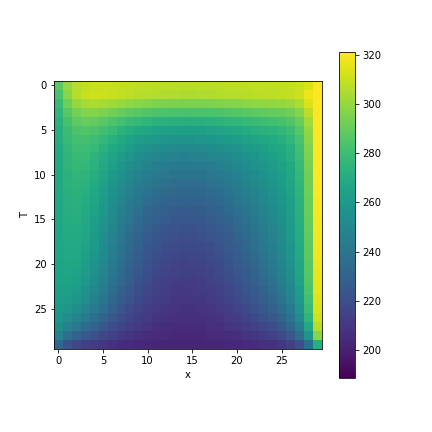
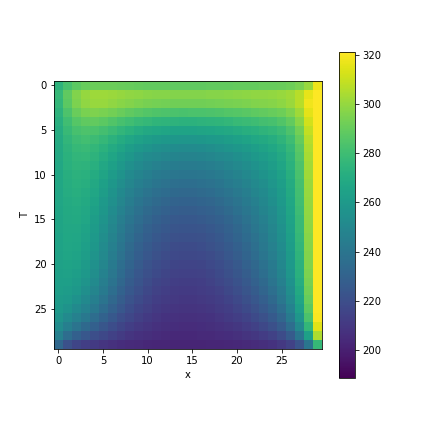
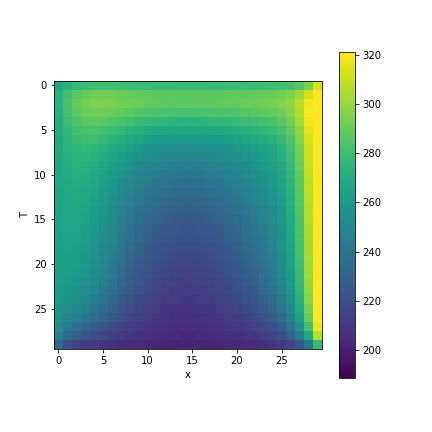
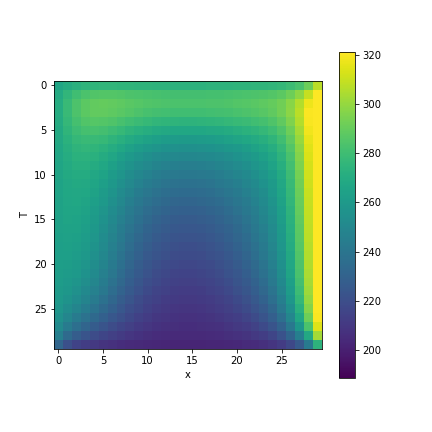
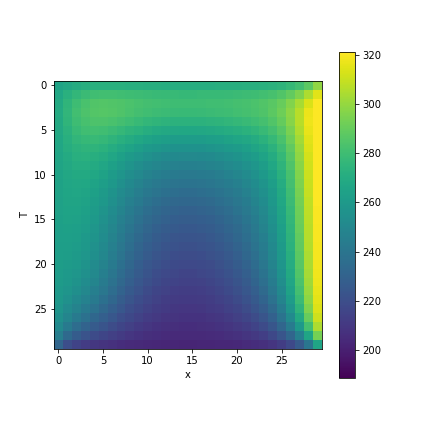
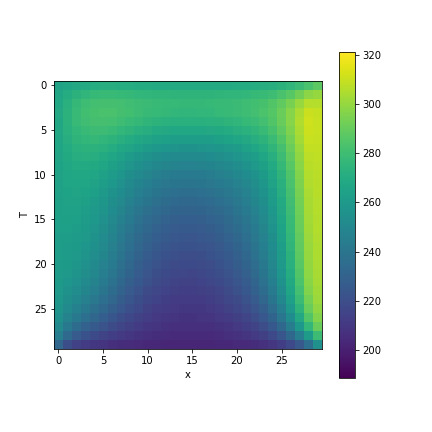
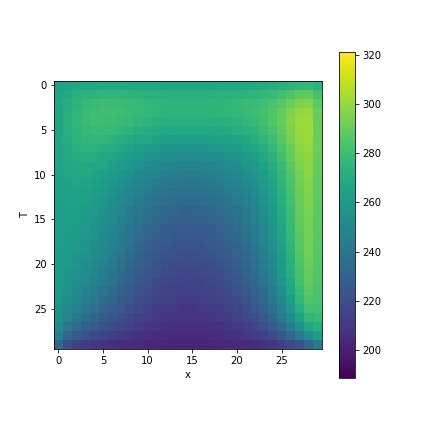
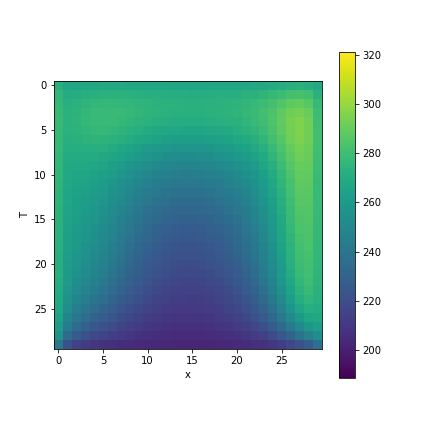
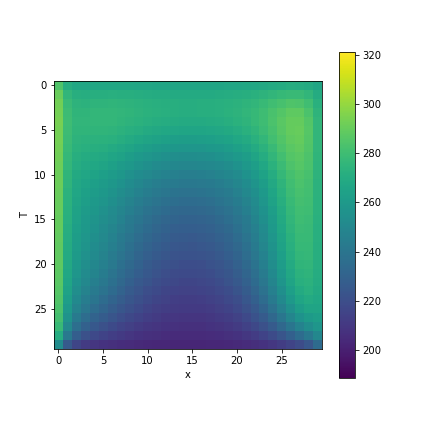
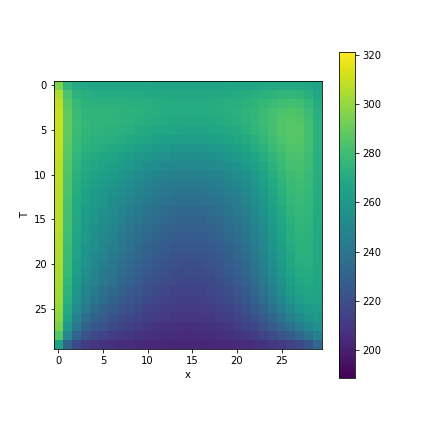
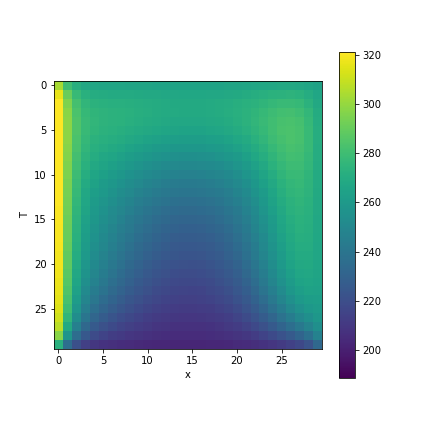
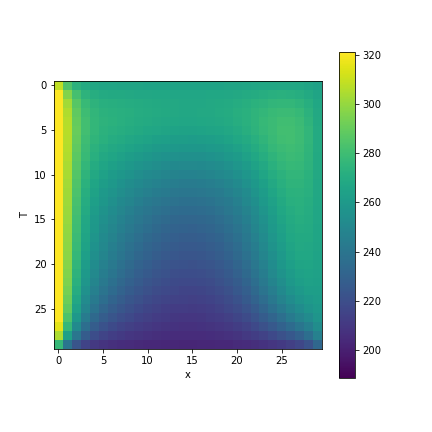
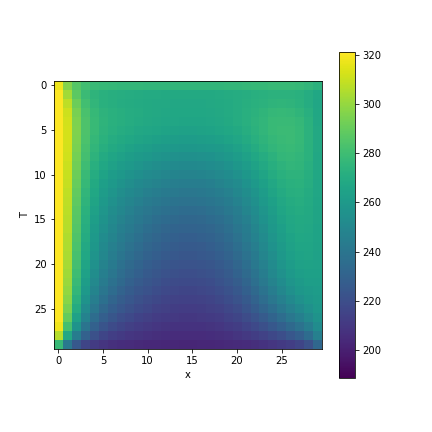
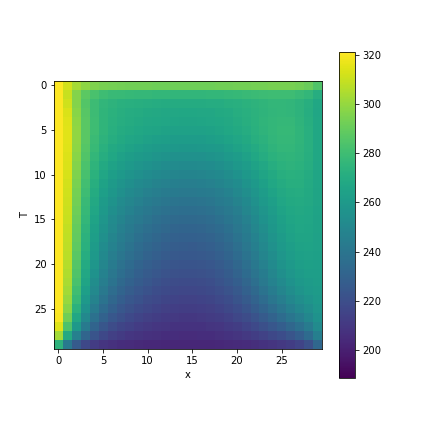
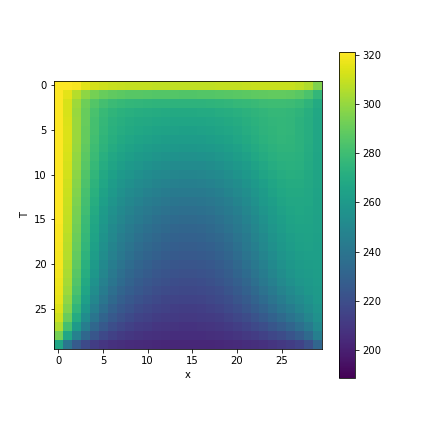
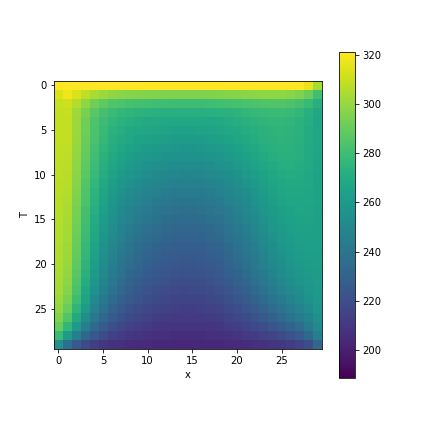
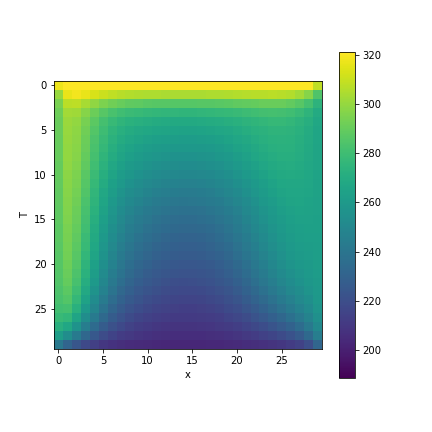
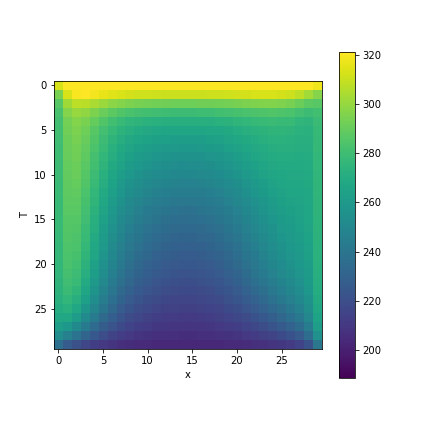
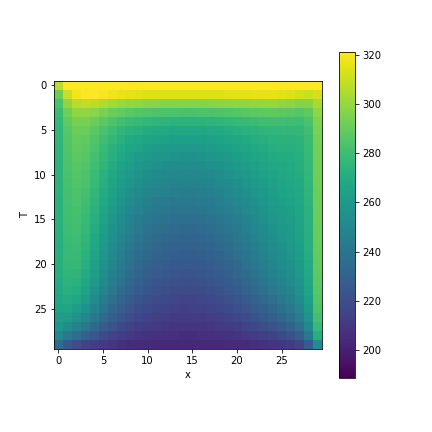
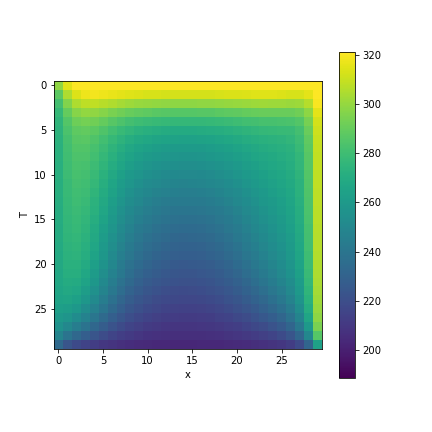
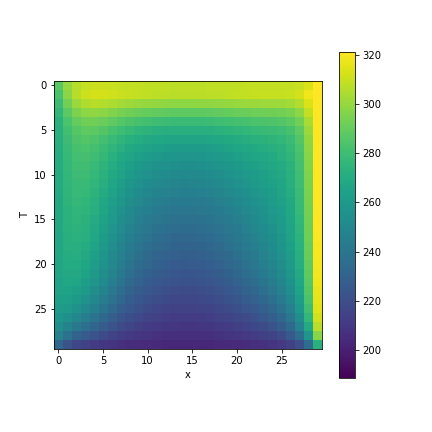

In [38]:
fig = figure(figsize = (6,6))
xlabel("x")
ylabel("T")

im = plt.imshow(ans2[99].reshape((rows, columns)), interpolation = 'none')
colorbar()

avg_maxTemp = 0
avg_minTemp = 0

# Animate results from odeint
def animate(i):
    im.set_data(ans2[i].reshape((rows, columns)))
    return im,

animation.FuncAnimation(fig, animate, frames = 150, interval = 60, blit = True)